학습된 모델을 blind test 하는 코드

In [1]:
# 학습 할때 몇 번째 gpu를 사용할것인지 설정
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="2"  # specify which GPU(s) to be used

In [2]:
# 경고 무시
import warnings
warnings.filterwarnings('ignore')
curdir = os.getcwd()
print(curdir)

/tf/repos_old/09_Variational/Code_old


In [3]:
# 서버 이름
import socket
hostname = socket.gethostname()
print(hostname)

f1b2c6893cf4


In [100]:
%matplotlib inline
import glob
import seaborn as sns
import tensorflow as tf
import numpy as np
import pandas as pd
import time
from tqdm import tqdm 
import pickle
import matplotlib.pyplot as plt

In [106]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, confusion_matrix
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model

In [6]:
print(tf.__version__)

2.8.0


In [7]:
np.random.seed(1234)

## 테스트 데이터 Load

In [10]:
loadFromPickle = True  #True #False

In [11]:
outdir_pickle = './pickle'
fn_pickle_pub = '{}/all_data_23.pickle'.format(outdir_pickle)
print(fn_pickle_pub)

../pickle/all_data_23.pickle


In [12]:
if loadFromPickle:
    if os.path.exists(fn_pickle_pub):
        print('{} exists....OK'.format(fn_pickle_pub))

        print('load from pickle files')
        file = open(fn_pickle_pub, 'rb')
        data = pickle.load(file)
        file.close()

        trainX = data[0]
        trainy = data[1]
        testX = data[2]
        testy = data[3] 
        data_name = data[4] 
        class_name = data[5]

../pickle/all_data_23.pickle exists....OK
load from pickle files


In [54]:
n_classes = len(class_name)
n_features = 6

In [14]:
print ('======================')
print('Train')
print ('Data : ', np.shape(trainX))
print ('Label : ',np.shape(trainy))
print ('======================')
print('Test')
print ('Data : ', np.shape(testX))
print ('Label : ', np.shape(testy))
print ('======================')

Train
Data :  (31851, 100, 7)
Label :  (31851, 7)
Test
Data :  (7976, 100, 7)
Label :  (7976, 7)


## 블라인드 데이터 Load

In [60]:
# 폴더에서 데이터를 불러오는 함수
def load_data_from_folder(folder):
    data = []
    # __로 시작하는 폴더를 제외한 폴더들 불러오기
    subfolders = sorted([f for f in os.listdir(folder) if not f.startswith('__')])
        
    for subfolder in subfolders:
        subfolder_path = os.path.join(folder, subfolder)
        files = sorted([f for f in os.listdir(subfolder_path) if not 'readme' in f and f.endswith('.txt')])
        for file in files:
            filepath = os.path.join(subfolder_path, file)
            data.extend(load_data_from_file(filepath))
    return data


# 파일에서 데이터를 불러오는 함수
def load_data_from_file(file):
    data = []
    try:
        data = pd.read_csv(file, sep="\t", header=None)
        data = data[[2, 3, 4, 5, 6, 7]].values.tolist() 
    except pd.errors.EmptyDataError:
        pass
        #print(f"File {file.split('/')[-1]} is empty. Skipping.")
    return data


# 시계열 데이터를 정규화하고 segment하는 함수
def segment_and_normalize_data(scaler, data, length, n_features):
    data = scaler.transform(data)
    segmented_data = []
    for i in range(0, len(data), length):
        if i+length > len(data): break
        segment = data[i:i+length]
        if len(segment) != length: continue
        segmented_data.append(segment.reshape(-1, n_features))
    return np.array(segmented_data)

def convert_to_one_hot(class_number, total_classes):
    one_hot = np.zeros(total_classes)
    one_hot[class_number] = 1
    return one_hot

def make_labels(data):
    n_classes = len(data)
    label = [None] * n_classes
    for i in range(n_classes):
        la = []
        for j in range(len(data[i])):
            la.append(convert_to_one_hot(i, n_classes))
        label[i] = la 
    return label

In [61]:
!pwd

/tf/repos_old/09_Variational/Code_old


In [40]:
data_dir = '../Dataset/05_blind_dataset'
folders = sorted([f for f in os.listdir(data_dir)])
folders

['C01_walking',
 'C02_standing',
 'C03_sitting',
 'C04_upstairs',
 'C05_downstairs',
 'C06_lying',
 'C07_running']

In [41]:
for i in range(n_classes):
    subfolders = sorted([f for f in os.listdir(data_dir+'/'+folders[i]) if not f.startswith('__')])
    print(data_dir+'/'+folders[i],'-->', len(subfolders))
    for j in range(len(subfolders)):
        print('   ├─', subfolders[j])
    print('')

../Dataset/05_blind_dataset/C01_walking --> 1
   ├─ 20210527_FossilSport0024_S353_C2000_walking_wjw_L

../Dataset/05_blind_dataset/C02_standing --> 1
   ├─ 20201227_FossilSport0024_S232_C07_Standing_hyejoo

../Dataset/05_blind_dataset/C03_sitting --> 1
   ├─ 20200925_S111_FossilMinseo_C00_sitting_reading_book

../Dataset/05_blind_dataset/C04_upstairs --> 1
   ├─ 20201205_FossilMinseo_S64_C05_Upstairs_27

../Dataset/05_blind_dataset/C05_downstairs --> 1
   ├─ 20201217_FossilMinseo_S132_C06_Downstairs_41

../Dataset/05_blind_dataset/C06_lying --> 1
   ├─ 20200925_FossilDalek_S15_C99_lying_nap

../Dataset/05_blind_dataset/C07_running --> 1
   ├─ 20210527_FossilSport0024_S363_C2009_jogging_wjw_L



In [46]:
nbsample_crop = 100

In [68]:
b_data = [None] * n_classes
nb_data = [None] * n_classes

# 데이터 로드
for i in range(n_classes):
    blind_data = load_data_from_folder(data_dir+'/'+folders[i])
    #print(np.shape(blind_data))
    b_data[i] = blind_data
    
# 정규화를 위한 scaler 학습
scaler = StandardScaler()
scaler.fit(np.concatenate(b_data))

# 시계열 데이터 정규화 및 segment
for i in range(n_classes):
    segmented_data = segment_and_normalize_data(scaler, b_data[i], nbsample_crop, n_features)
    print(np.shape(segmented_data))
    nb_data[i] = segmented_data

# Label 생성
label = make_labels(nb_data)

# blind 데이터 최종형태
blindX = np.concatenate(nb_data)
blindy = np.concatenate(label)

(125, 100, 6)
(75, 100, 6)
(75, 100, 6)
(45, 100, 6)
(55, 100, 6)
(105, 100, 6)
(35, 100, 6)


In [69]:
np.shape(blindX), np.shape(blindy)

((515, 100, 6), (515, 7))

## 모델 Load 및 테스트

In [71]:
fnmodel = './out/Conv1D_cls7_epoch100_len100/model_Conv1D_cls7_epoch100_len100.h5'
model = load_model(fnmodel)

In [72]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 98, 64)            1216      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 49, 64)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 47, 128)           24704     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 23, 128)          0         
 1D)                                                             
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                        

In [78]:
blind_pred = model.predict(blindX)

In [93]:
blindy1 = np.argmax(blindy, axis=1)
blind_pred1 = np.argmax(blind_pred, axis=1)

In [102]:
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    df_cm = pd.DataFrame(cm_norm, index=class_names, columns=class_names)
    fig, ax = plt.subplots(figsize=(7,6))
    sns.heatmap(df_cm, annot=True, fmt=".2f", cmap='binary', annot_kws={"size": 16}, ax=ax)

    # Adding the outline (grid on the outside)
    for _, spine in ax.spines.items():
        spine.set_visible(True)
    
    # Adding the outline
    for i in range(len(df_cm.columns)):
        ax.hlines(i, *ax.get_xlim(), color='black', linewidth = 0.3)
        ax.vlines(i, *ax.get_ylim(), color='black', linewidth = 0.3)

    plt.title('Blind Confusion Matrix', size=10)
    plt.ylabel('True label', size=10)
    plt.xlabel('Predicted label', size=10)

    plt.show()

In [103]:
np.shape(blindy)

(515, 7)

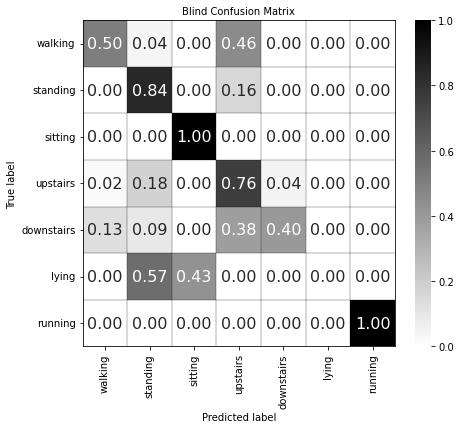

In [104]:
plot_confusion_matrix(blindy1, blind_pred1, class_name)

In [107]:
emb_model = Model(model.input, model.layers[-2].output)
emb_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_input (InputLayer)   [(None, 100, 6)]          0         
                                                                 
 conv1d (Conv1D)             (None, 98, 64)            1216      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 49, 64)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 47, 128)           24704     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 23, 128)          0         
 1D)                                                             
                                                                 
 global_average_pooling1d (G  (None, 128)              0     

In [121]:
# dataset 구분하는 마지막 column은 제거

if np.shape(testX)[-1] == 7:
    testX = testX[:,:,:6]
    
testy1 = np.argmax(testy, axis=1)

In [112]:
testXX = np.vstack((testX, blindX))
testyy = np.vstack((testy, blindy))

In [113]:
embedding = emb_model.predict(testXX)
print(embedding.shape)

(8491, 128)


In [117]:
from sklearn.manifold import TSNE

In [118]:
# %%time
proj = TSNE(n_components=2).fit_transform(embedding)

In [119]:
cmp = plt.get_cmap("tab20") 

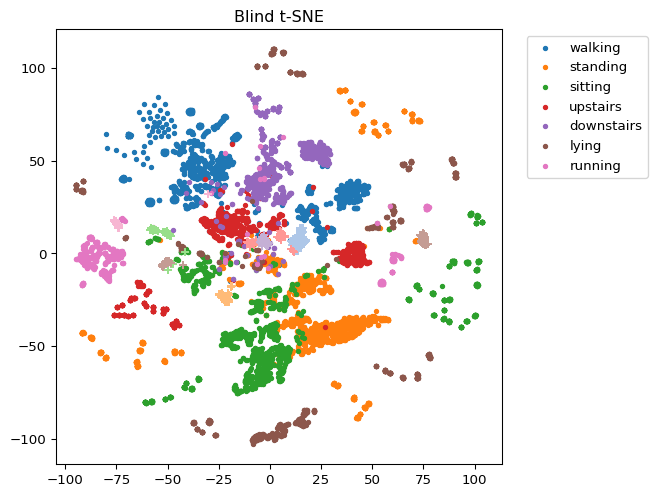

In [124]:
plt.figure(figsize=(6,6), dpi=96)

proj1 = proj[:len(testX)]
proj2 = proj[len(testX):]

for i in range(n_classes):
    select_flag = testy1 == i
    plt_latent = proj1[select_flag, :]
    plt.scatter(plt_latent[:, 0], plt_latent[:, 1], color=cmp(i*2), marker=".")

for i in range(n_classes):
    select_flag = blindy1 == i
    plt_latent_vae = proj2[select_flag, :]
    plt.scatter(plt_latent_vae[:, 0], plt_latent_vae[:, 1], color=cmp((i+1)*2-1), marker="+")

title = 'Blind t-SNE'
plt.title(title)
plt.gca().legend(class_name, bbox_to_anchor=(1.04,1), loc="upper left")
# plt.savefig(fnfig, bbox_inches = "tight")
plt.show()